## DCB eksperiment

In [5]:
%matplotlib inline

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

In [7]:
uzorak = input()
#npr. "A30-01"

A60-02


In [8]:
B = float("0.0"+uzorak[1:3]) # given by input e.g. B = 30 mm
h = 0.006 # height approx 6 mm
E_s = 7 * 10**10 # ALU

In [9]:
shift = 0 # defined later
stages = 1971

### TestXpert


In [10]:
korak = 5 #time step 0.5 sec (2 Hz)

In [11]:
data = np.genfromtxt(uzorak + "\\" + uzorak + ".csv", delimiter=',', skip_header=3, names=['pomak','sila','vrijeme'])
#pos = data['sila']>0
#P[P<0] = 0
u = 1/1000 * data['pomak'][:korak*stages][::korak]
P = data['sila'][:korak*stages][::korak]
t = data['vrijeme'][:korak*stages][::korak]
#računa se samo za prvih 1000 sec jer nakon 1000 sekundi kidalica promijeni delta_t
prop = [i for i in range(np.argmax(P),stages)]

### Aramis

In [12]:
aramis = np.genfromtxt(uzorak+"\\CSV\\"+uzorak+"-00-check.csv", delimiter=',', skip_header=1)/1000
u_dic = aramis[shift*2:stages+shift*2,1]
u_sync = aramis[:stages,2]

In [13]:
shift = (np.argmax(u_sync>0.001) - np.argmax(u>0.001))//2
u_dic_raw = aramis[(shift*2):(stages+shift*2),1]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


#### KOREKCIJA 1 - provjera sinkronizacije
Pomak prihvatnih blokova u iznosu od 1 mm mora biti sinkronizirano zabilježen na kidalici i na Aramisu. Sinkronizacija se provodi pomoću gore navedenog izraza: 
shift = (index(pomak 0,1mm zabilježen na kidalici) - index(pomak 0,1mm zabilježen na Aramisu)) * (1/2Hz)

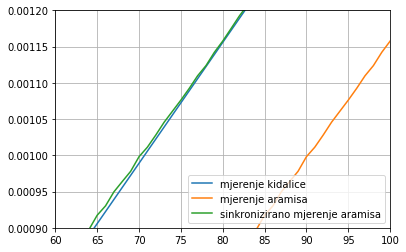

In [14]:
plt.plot(u,label="mjerenje kidalice")
plt.plot(u_sync,label="mjerenje aramisa")
plt.plot(aramis[(shift*2):(stages+shift*2),2],label="sinkronizirano mjerenje aramisa")
plt.ylim(0.0009,0.0012)
plt.xlim(60,100)
plt.grid()
plt.legend()

#### KOREKCIJA 2 - pomicanje grafa
Graf sila-pomak mora biti pomaknut na način da derivacija područja 0,5-1,0 mm prolazi kroz ishodište.

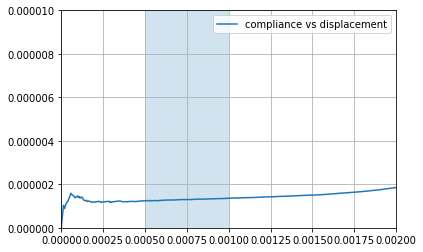

In [15]:
plt.plot(u_dic_raw,(u_dic_raw/P), label='compliance vs displacement')
plt.ylim(0,0.00001)
plt.xlim(0,0.002)
plt.axvspan(0.0005,0.0010,alpha=0.2)
plt.grid()
plt.legend()

In [16]:
podrucje = np.s_[np.argmax(u_dic_raw>0.0005):np.argmax(u_dic_raw>0.0010)]

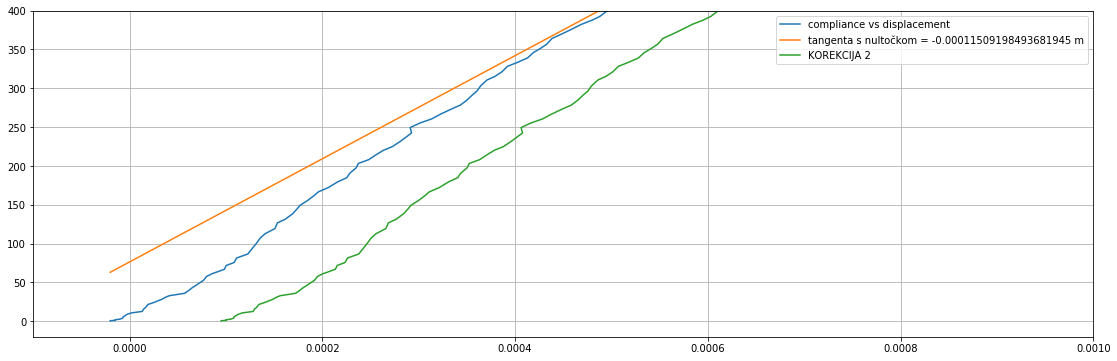

In [17]:
tang = np.poly1d(np.polyfit(u_dic_raw[podrucje],P[podrucje],1))
K2 = np.roots(tang)
plt.figure(figsize=(19,6))
plt.plot(u_dic_raw,P, label='compliance vs displacement')
plt.plot(u_dic_raw,tang(u_dic_raw), label='tangenta s nultočkom = '+str(K2.item())+" m")
plt.ylim(-20,400)
plt.xlim(-0.0001,0.0010)
plt.grid()
plt.plot(u_dic_raw-K2,P, label='KOREKCIJA 2')
plt.legend()

In [18]:
u_dic = u_dic_raw - K2

In [19]:
crack_width_0 = 0.05 #input

In [20]:
a_dic = np.zeros((stages))
complete = np.empty((200,stages))
for i in range(stages): #in prop ??
    stage = np.genfromtxt(uzorak+"\\CSV\\"+uzorak+"-"+str(i+shift*2)+".csv", delimiter=',', skip_header=1) # .... prepraviti ...
    a_dic[i]= 0.001*(stage[(np.argmax(stage[:,1]<crack_width_0)),0])
    complete[:,i] = np.interp(np.arange(0,200,1),stage[:,0],stage[:,1])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


In [21]:
def deflection(stage,distance):
    fig, axes = plt.subplots(1, 2, figsize=(15, 4))
    axes[1].plot(complete[:,stage])
    axes[0].plot(complete[distance,:])
    axes[1].set_ylim(0,30)
    axes[0].set_ylim(0,20)
    
interact(deflection, stage=(0, stages, 25), distance=(0,200,5))

interactive(children=(IntSlider(value=975, description='stage', max=1971, step=25), IntSlider(value=100, descr…

<function __main__.deflection(stage, distance)>

### Analysis method 1: Simple beam theory (SBT) (see Annex D)
ISO 25217:2009(E)

Measure $E_s$ from an independent modulus test or quote it if a standard grade of material is used.

Calculate $G_{IC}$ from Equation (2) for the SBT method.

$$ G_{IC} = \frac{4P^2}{E_sB^2} \Big( \frac{3a^2}{h^3}+\frac{1}{h} \Big)= \frac{4P^2}{E_sB^2} m $$


In [22]:
G_IC_1 = 4*P**2/(E_s*B**2) * (3*a_dic**2/h**3 + 1/h)

### Analysis method 2: Corrected beam theory (CBT) 
ISO 25217:2009(E)

Treat the beam as containing a slightly longer crack length, $(a + |Δ|)$; find $|Δ|$ experimentally by plotting the
cube root of the compliance, $C^{1/3}$.

Extrapolate a linear fit through the data in the plot to yield $Δ$ as the negative X-intercept. Use only the
propagation (PROP) values for the linear fits, i.e. exclude all the initiation values from the linear fits.


$$ G_{IC} = \frac{3P\delta}{2B(a+|\Delta|)} F $$

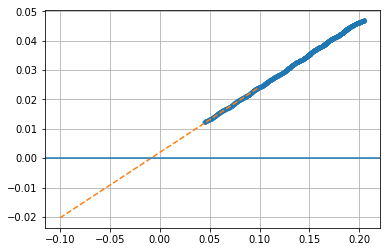

In [23]:
x2=np.linspace(-0.1,0.1,10)
p2 = np.poly1d(np.polyfit(a_dic[prop],(u_dic[prop]/P[prop])**(1/3),1)) #ima li druga funkcija za pravac?
plt.plot(a_dic[prop],(u_dic[prop]/P[prop])**(1/3),'.',x2,p2(x2),'--') # , label='compliance vs crack length'
plt.axhline(y=0)
plt.grid()
delta = -np.roots(p2)

In [24]:
delta

array([0.00862867])

In [25]:
G_IC_2 = 3*P*u_dic/(2*B*(a_dic+delta)) # * F - za velike pomake

### Analysis method 3: Experimental compliance method (ECM) or Berry's method
Protocol for the Determination of the Mode I Adhesive Fracture Energy, GIC, of Structural Adhesives using the Double Cantilever Beam (DCB) and Tapered Double Cantilever Beam (TDCB) Specimens. (Version 00-08.  B.R.K. Blackman and A.J. Kinloch.  22-06-00)



An  alternative  approach  is  to  plot  the  logarithm of  the  compliance  C,  or  of  the  normalised  compliance,  C/N,  if  load-blocks  are  being  used,  versus  the  logarithm  of  the  crack  length  a  as  shown in Figure 3. Only the propagation (PROP) values are used for the linear fits, i.e. all the initiation  values  are  excluded  from  the  regression  analysis.  The  slope  of  this  plot,  n,  can  then  be used to give $G_{IC}$ as follows:

$$ G_{IC} = \frac{nP\delta}{2Ba} $$

with  P  the  load,  δ  the  displacement,  a  the  crack  length,  and  B  the  width  of  the  specimen.  All  initiation  and  propagation  values  of  GIC,  if  applicable,  should  be  calculated.  The  same  large-displacement  correction  F  and  load-block  correction  N,  if  applicable,  are  used  as  for  the corrected beam theory method (see above)

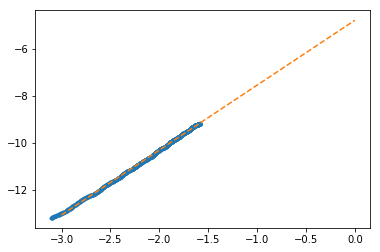

In [26]:
x3=np.linspace(-3,0,10)
p3 = np.poly1d(np.polyfit(np.log(a_dic[prop]),np.log(u_dic[prop]/P[prop]),1))
plt.plot(np.log(a_dic[prop]),np.log((u_dic[prop]/P[prop])),'.',x3,p3(x3),'--')
n = p3[1]

In [27]:
G_IC_3 = n*P*u_dic/(2*B*a_dic)

#### J - integral

In [28]:
theta = np.genfromtxt(uzorak+"\\CSV\\"+uzorak+"-00-J-integral.csv", delimiter=',', skip_header=1)[shift*2:stages+shift*2,1]
J = np.radians(theta) * P / B

#### Constitutive law

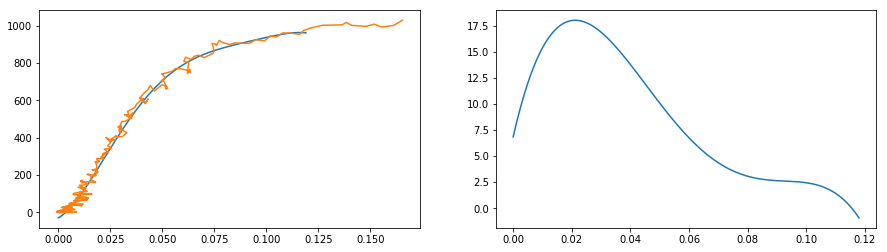

In [29]:
delta_ct = np.arange(0,0.12,0.001)
asdf = 40
z = np.polyfit(delta_ct, np.interp(delta_ct,complete[asdf,:],J), 5)
p = np.poly1d(z)
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
axes[0].plot(delta_ct,p(delta_ct),complete[asdf,:][:230],J[:230])
axes[1].plot(delta_ct[:-1],0.001*np.diff(p(delta_ct))/np.diff(delta_ct))

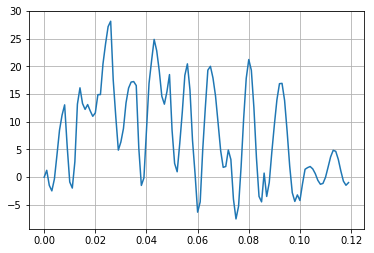

In [30]:
from scipy.signal import savgol_filter
sigma = savgol_filter(np.interp(delta_ct,complete[39,:],J), window_length=15, polyorder=5, deriv=1, mode='nearest')
plt.plot(delta_ct,sigma)
plt.grid()

#### SBT-E

In [31]:
a_EQ = np.cbrt((3*(u_dic)*E_s*B*h**3/12)/(2*P)) #u_dic+0.0007 je prepravak sinkronizacije?
G_IC_EQ = P**2 * a_EQ**2 /(B*E_s*(B*h**3/12))

#### ESBT

In [32]:
ni = 0.367 #Experimental estimation of the mechanical and fracture properties of a new epoxy adhesive
mi = 0.5*E_s/(1+ni)
alpha = (5/6 *B*h*mi)/(E_s*(B*h**3/12))
a_EQ_2 = np.cbrt((1/np.sqrt(alpha))**3+a_EQ**3)-1/np.sqrt(alpha)
G_IC_EQ_2 = P**2 * ( a_EQ**2 /(B*E_s*(B*h**3/12)) + (1+2*a_EQ_2*np.sqrt(alpha))/(5/6 *B*h*mi) )

In [33]:
#plot d(a_EQ)/d(d_dic)

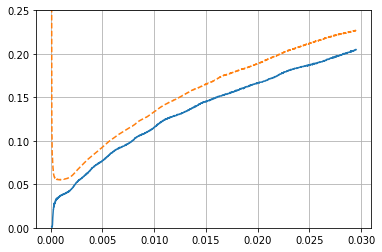

In [34]:
plt.plot(u_dic,a_dic,u_dic,a_EQ,"--")
plt.ylim(0,0.25)
plt.grid()

### Results

In [35]:
SBT = round(np.mean(G_IC_1[prop]),2)
CBT = round(np.mean(G_IC_2[prop]),2)
ECM = round(np.mean(G_IC_3[prop]),2)
SBT_E = round(np.mean(G_IC_EQ[prop]),2)
ESBT = round(np.mean(G_IC_EQ_2[prop]),2)
J_int = round(np.mean(J[prop]),2)

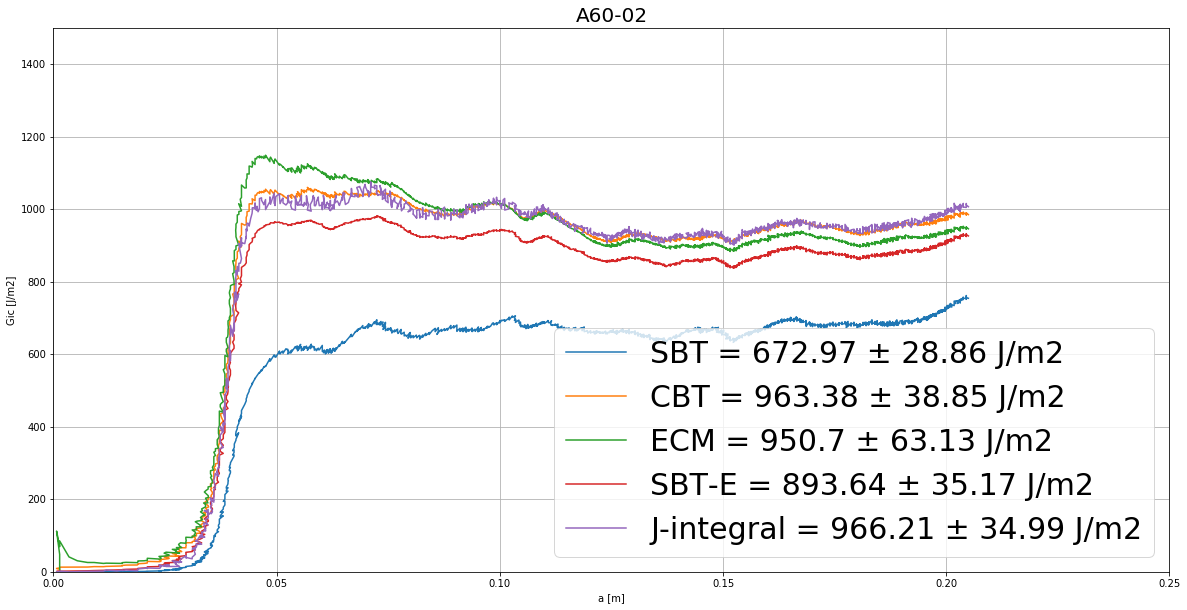

In [36]:
plt.figure(figsize=(20,10))
plt.title(uzorak, fontsize=20)
plt.plot(a_dic,G_IC_1,label=("SBT = "+str(SBT)+" ± " +str(round(np.std(G_IC_1[prop]),2))+ " J/m2 "))
plt.plot(a_dic,G_IC_2,label=("CBT = "+str(CBT)+" ± " +str(round(np.std(G_IC_2[prop]),2))+ " J/m2"))
plt.plot(a_dic,G_IC_3,label=("ECM = "+str(ECM)+" ± " +str(round(np.std(G_IC_3[prop]),2))+ " J/m2"))
plt.plot(a_dic,G_IC_EQ,label=("SBT-E = "+str(SBT_E)+" ± " +str(round(np.std(G_IC_EQ[prop]),2))+ " J/m2"))
#plt.plot(a_dic,G_IC_EQ_2,label=("ESBT = "+str(ESBT)+" ± " +str(round(np.std(G_IC_EQ_2[prop]),2))+ " J/m2"))
plt.plot(a_dic,J,label=("J-integral = "+str(J_int)+" ± " +str(round(np.std(J[prop]),2))+ " J/m2"))
plt.xlim(0,0.25)
plt.ylim(0,1500)
plt.xlabel("a [m]")
plt.ylabel("Gic [J/m2]")
plt.grid()
#plt.style.use('grayscale')

plt.legend(loc=4,fontsize=30)
plt.rc('axes', labelsize=25)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.savefig(uzorak)

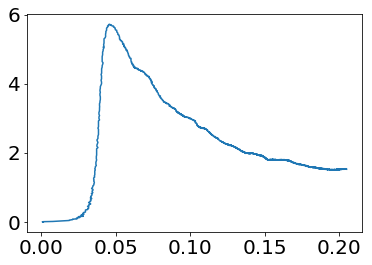

In [37]:
plt.plot(a_dic,G_IC_EQ_2-G_IC_EQ)

In [38]:
np.savetxt(uzorak+" pomak-sila.csv",np.column_stack((u_dic[::6]*1000,P[::6])), delimiter=',') #header="pomak,sila")

### print rješenja na kraju

napraviti ipynb koji otvara i uspoređuje rješenja...

ubaciti tabelu s $G_{IC}$ za razne materijale prema literaturi radi usporedbe

In [39]:
#np.savetxt(uzorak+"_results.csv",np.vstack((a_dic,G_IC_1,G_IC_2,G_IC_3,G_IC_EQ)))

In [40]:
complete_fronta = np.empty((34,stages))
for i in range(stages):
    fronta = np.genfromtxt(uzorak+"\\CSV\\fronta\\"+uzorak+"-"+str(i)+"fronta.csv", delimiter=',', skip_header=1) # .... prepraviti ...
    complete_fronta[:,i] = fronta[:,1]
length = fronta[:,0]

In [41]:
def graf(stage):
    asdf = complete_fronta[:,stage]
    x = np.arange(0,complete_fronta.shape[0],1)
    plt.plot(length ,asdf-np.interp(x,(x[0],x[-1]),(asdf[0],asdf[-1])),label="fronta")
    plt.ylim(0,0.1)
    plt.grid()
    plt.show()

interact(graf, stage=(0, 2000,50))


interactive(children=(IntSlider(value=1000, description='stage', max=2000, step=50), Output()), _dom_classes=(…

<function __main__.graf(stage)>